In [1]:
import tweepy 
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import csv



from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.regularizers import l1_l2, l2, l1


Using TensorFlow backend.


In [2]:
df = pd.read_pickle("Dataset/TweetsDataset.pkl")


#df = pd.read_csv('Dataset\Tweets.csv', encoding='latin-1')

In [3]:
data=df
df=df.astype(str)

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from IPython.core.interactiveshell import InteractiveShell


In [5]:
df

,Unnamed: 0,Tweets,Emotion,Writer
0,0,iÃ¢ÂÂm proud to endorse this diverse and hop...,Positive,BarackObama
1,1,welcome home astrobehnken and astrodoug we lau...,Positive,BarackObama
2,2,this pandemic is far from overÃ¢ÂÂÃ¢ÂÂand ...,Trust,BarackObama
3,3,john believed that in all of us there exists t...,Positive,BarackObama
4,4,john spent his entire life fighting for justic...,Neagtive,BarackObama
...,...,...,...,...
12104,12104,for a minute there i was all happy thinking it...,Anticipation,Random
12105,12105,for the first time ever my iphone crashed itun...,Neagtive,Random
12106,12106,for trish sa right side ng reply ko may star a...,Positive,Random
12107,12107,forgot about them science exams tbh n,Neutral,Random


In [6]:
df.loc[df['Writer'] == 'BarackObama', 'Writer'] = 'BarackObama'
df.loc[df['Writer'] == 'BillGates', 'Writer'] = 'BillGates'
df.loc[df['Writer'] == 'HillaryClinton', 'Writer'] = 'HillaryClinton'
df.loc[df['Writer'] == 'BorisJohnson', 'Writer'] = 'BorisJohnson'
df.loc[df['Writer'] == 'JeremyCorbyn', 'Writer'] = 'JeremyCorbyn'
df.loc[df['Writer'] == 'Random', 'Writer'] = 'Random'

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Tweets'] = df['Tweets'].apply(clean_text)

In [8]:
#df['Tweets'] = df['Tweets'].str.replace('\d+', '')
df['Tweets']= df[['Tweets', 'Emotion']].agg('-'.join, axis=1)


In [9]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

#EMBEDDING_DIM = 40

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Tweets'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 24804 unique tokens.


In [10]:
X = tokenizer.texts_to_sequences(df['Tweets'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (24218, 250)


In [11]:
Y = pd.get_dummies(df['Writer']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (24218, 6)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(19374, 250) (19374, 6)
(4844, 250) (4844, 6)


In [13]:

from keras.layers.convolutional import Conv1D
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, activation='tanh'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())














Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 5,118,022
Trainable params: 5,118,022
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
epochs = 6
batch_size = 256
#batch_size = 64


history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)


C:\Users\Alee\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/6
19374/19374 [==============================] - 203s 10ms/step - loss: 1.5460 - accuracy: 0.3740
Epoch 2/6
19374/19374 [==============================] - 221s 11ms/step - loss: 0.6435 - accuracy: 0.7794
Epoch 3/6
19374/19374 [==============================] - 240s 12ms/step - loss: 0.2427 - accuracy: 0.9262
Epoch 4/6
19374/19374 [==============================] - 248s 13ms/step - loss: 0.1130 - accuracy: 0.9693
Epoch 5/6
19374/19374 [==============================] - 224s 12ms/step - loss: 0.0572 - accuracy: 0.9854
Epoch 6/6
19374/19374 [==============================] - 279s 14ms/step - loss: 0.0373 - accuracy: 0.9917


In [15]:
accr = model.evaluate(X_test,Y_test)


4844/4844 [==============================] - 29s 6ms/step


In [16]:
accr[1]


0.9593311548233032

In [17]:
new_complaint = ["""

Coronavirus means we can’t celebrate Pride Month in the way we usually would, standing shoulder to shoulder and marching in pride. 

But 
@UKLabour
 want all LGBT+ people to know that we’re with you, this month and every month Rainbow flag

#PrideMonth2020 #Pride2020 -Negative


"""]
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(np.argmax(pred))

BorisJohnson


In [ ]:

#################################################################################################################################label=['BarackObama', 'BillGates', 'BorisJohnson','HillaryClinton', 'JeremyCorbyn',  'Random']
#############################################################################################################################print(label[np.argmax(pred)])

In [18]:
predictions = model.predict(X_test)

In [19]:
y_pred = (predictions > 0.5)

In [20]:

from sklearn.metrics import classification_report

print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1)))


              precision    recall  f1-score   support

           0       0.91      0.96      0.94       796
           1       0.97      0.96      0.97       827
           2       0.98      0.97      0.97       789
           3       0.95      0.93      0.94       821
           4       0.96      0.96      0.96       807
           5       0.97      0.96      0.96       804

    accuracy                           0.96      4844
   macro avg       0.96      0.96      0.96      4844
weighted avg       0.96      0.96      0.96      4844



In [21]:
#classification_report(Y_test, y_pred, target_names=labels, output_dict=True)

In [22]:
from sklearn.metrics import precision_score
precision=precision_score(Y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro')

C:\Users\Alee\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [23]:
from sklearn.metrics import recall_score

recall=recall_score(Y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro')


In [24]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(Y_test, y_pred)


In [25]:
dict = {
  "Accuracy": accuracy,
  "Precision": precision,
  "Recall": recall
}

In [26]:
import pickle
file = open('Accuracies/LSTM', 'wb')
pickle.dump(dict, file)
file.close()

In [27]:
    file = open('Accuracies/LSTM', 'rb')
    Accuracy = pickle.load(file)
    file.close()
    print(Accuracy["Accuracy"])
    print(Accuracy["Precision"])
    print(Accuracy["Recall"])
    

0.9543765483071841
0.9681675392670157
0.9543765483071841


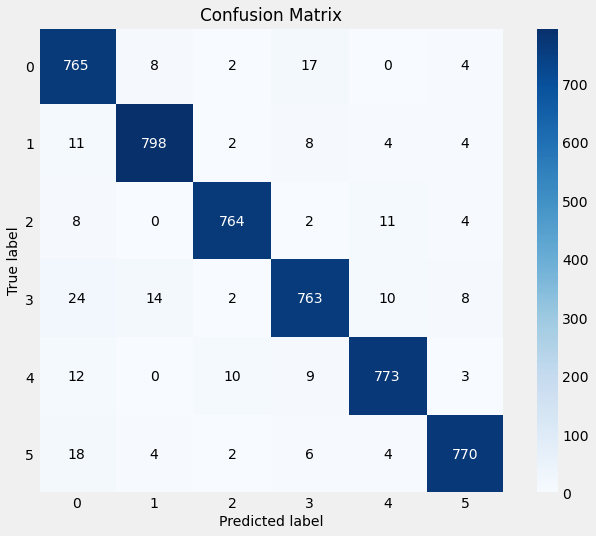

In [28]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    Y_test.argmax(axis=1), y_pred.argmax(axis=1),
    figsize=(10,8))